# Importing Libraries


In [ ]:
import matplotlib.pyplot as plt
import opendatasets as od
import os

#Deep Learning Libraries

from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Data Fetching

In [ ]:
!pip install opendatasets

In [ ]:
#Fetching data from Kaggle
# This ensures we have access to the necessary data for training and validation.
od.download("https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kawserayoub00
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset


100%|██████████| 121M/121M [00:06<00:00, 18.6MB/s]


In [ ]:
folder_path = "./face-expression-recognition-dataset/images/"

#Displaying Images

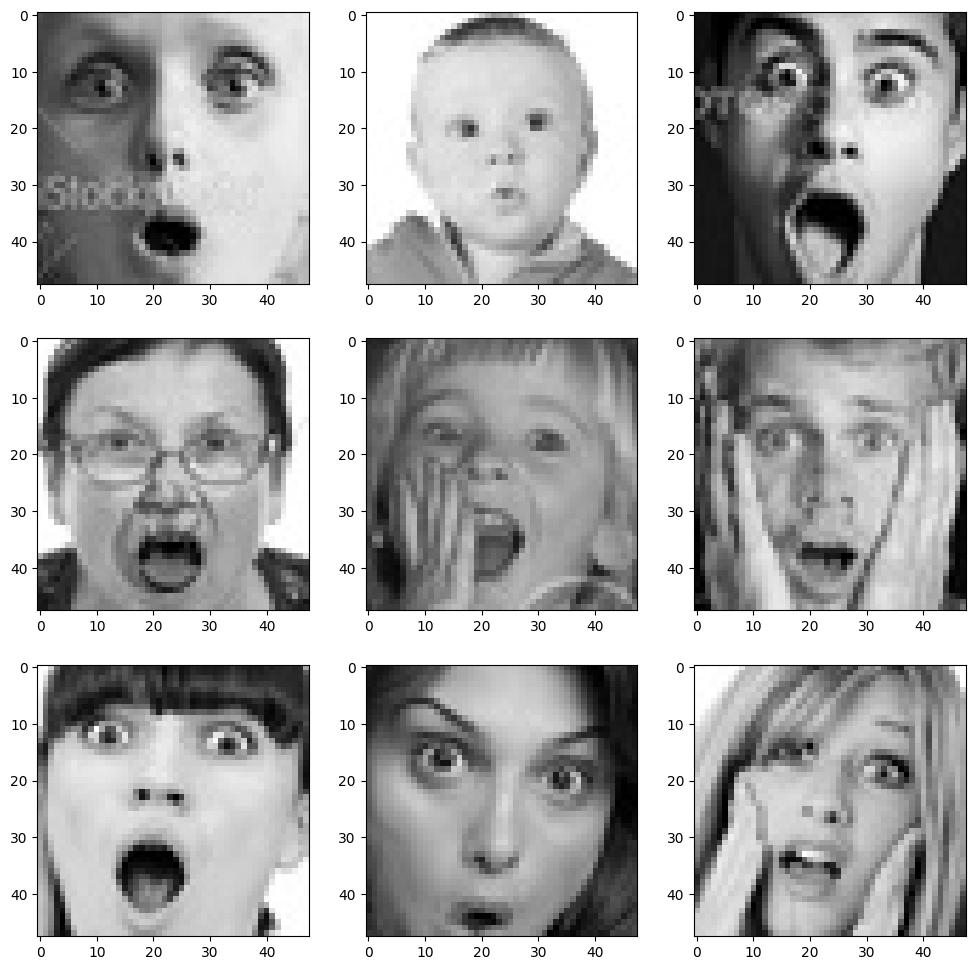

In [ ]:
# Visualize sample images from the dataset to understand the data and check if the images are loaded correctly.
expression = 'surprise'

plt.figure(figsize=(12,12))
for i in range(1,10,1):
    plt.subplot(3,3,i)
    img=load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(48, 48))
    plt.imshow(img)
plt.show()

# Training and Validation Data

In [ ]:
# Prepare the training and validation data with augmentation to improve model generalization.
# Augmentation helps in creating more diverse training examples.

batch_size = 128

datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,)

datagen_val = ImageDataGenerator(rescale=1./255)

train_set = datagen_train.flow_from_directory(
    folder_path+'train',
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical')

test_set = datagen_val.flow_from_directory(
    folder_path+'validation',
    target_size=(48,48),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical')

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Defining the Model


In [ ]:
# Define the convolutional neural network (CNN) model architecture.
# The model is designed to classify facial expressions based on the input images.

model = Sequential([

    #Layer 1
    Conv2D(512, (5, 5), padding='same', kernel_initializer='he_normal',
    input_shape=(48, 48, 1)),
    BatchNormalization(),
    Activation('elu'),

    #Layer 2
    Conv2D(256, (5, 5), padding='same',kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('elu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    #Layer 3
    Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('elu'),

    #Layer 4
    Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('elu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    #Layer 5
    Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('elu'),

    #Layer 6
    Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('elu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    #Flattening Layer
    Flatten(),

    #Fully Connected Layer
    Dense(256, kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('elu'),
    Dropout(0.25),

    #Output Layer
    Dense(7, activation='softmax')
])

# Compile the model with an optimizer and loss function.
# This sets up the model for training, specifying how it will learn and how performance will be measured.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 48, 48, 512)       13312     
                                                                 
 batch_normalization_28 (Ba  (None, 48, 48, 512)       2048      
 tchNormalization)                                               
                                                                 
 activation_28 (Activation)  (None, 48, 48, 512)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 48, 48, 256)       3277056   
                                                                 
 batch_normalization_29 (Ba  (None, 48, 48, 256)       1024      
 tchNormalization)                                               
                                                                 
 activation_29 (Activation)  (None, 48, 48, 256)      

# Fitting the Model

In [ ]:
# Setup callbacks for training.
# EarlyStopping prevents overfitting by stopping early if performance doesn't improve.
# ModelCheckpoint saves the best model based on validation accuracy.
# ReduceLROnPlateau reduces the learning rate if the model stops improving.

call_backs_list = [
    EarlyStopping(monitor='val_accuracy', min_delta=0.00005, patience=11, verbose=1, restore_best_weights=True),
    ModelCheckpoint("./model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=7, min_lr=1e-7, verbose=1)]

In [ ]:
# Train the model using the training and validation data.
# The model is trained for a specified number of epochs, and the callbacks help in managing the training process.

epochs = 50
history = model.fit(train_set,
                    steps_per_epoch=train_set.n//train_set.batch_size,
                    epochs=epochs,
                    validation_data = test_set,
                    validation_steps = test_set.n//test_set.batch_size,
                    callbacks=call_backs_list
                    )

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 1.9506 - accuracy: 0.2489
Epoch 1: val_accuracy improved from -inf to 0.32060, saving model to ./model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 [==============================] - 110s 371ms/step - loss: 1.9506 - accuracy: 0.2489 - val_loss: 1.7045 - val_accuracy: 0.3206 - lr: 0.0010
Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 1.7329 - accuracy: 0.3168
Epoch 2: val_accuracy improved from 0.32060 to 0.37997, saving model to ./model.h5
225/225 [==============================] - 84s 371ms/step - loss: 1.7329 - accuracy: 0.3168 - val_loss: 1.5673 - val_accuracy: 0.3800 - lr: 0.0010
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 1.5881 - accuracy: 0.3824
Epoch 3: val_accuracy improved from 0.37997 to 0.43210, saving model to ./model.h5
225/225 [==============================] - 84s 371ms/step - loss: 1.5881 - accuracy: 0.3824 - val_loss: 1.5214 - val_accuracy: 0.4321 - lr: 0.0010
Epoch 4/50
225/225 [==============================] - ETA: 0s - loss: 1.4705 - accuracy: 0.4349
Epoch 4: val_accuracy improved from 0.43210 to 0.49957, saving model to ./model.h5
225/225 [============

# Plotting Accuracy & Loss


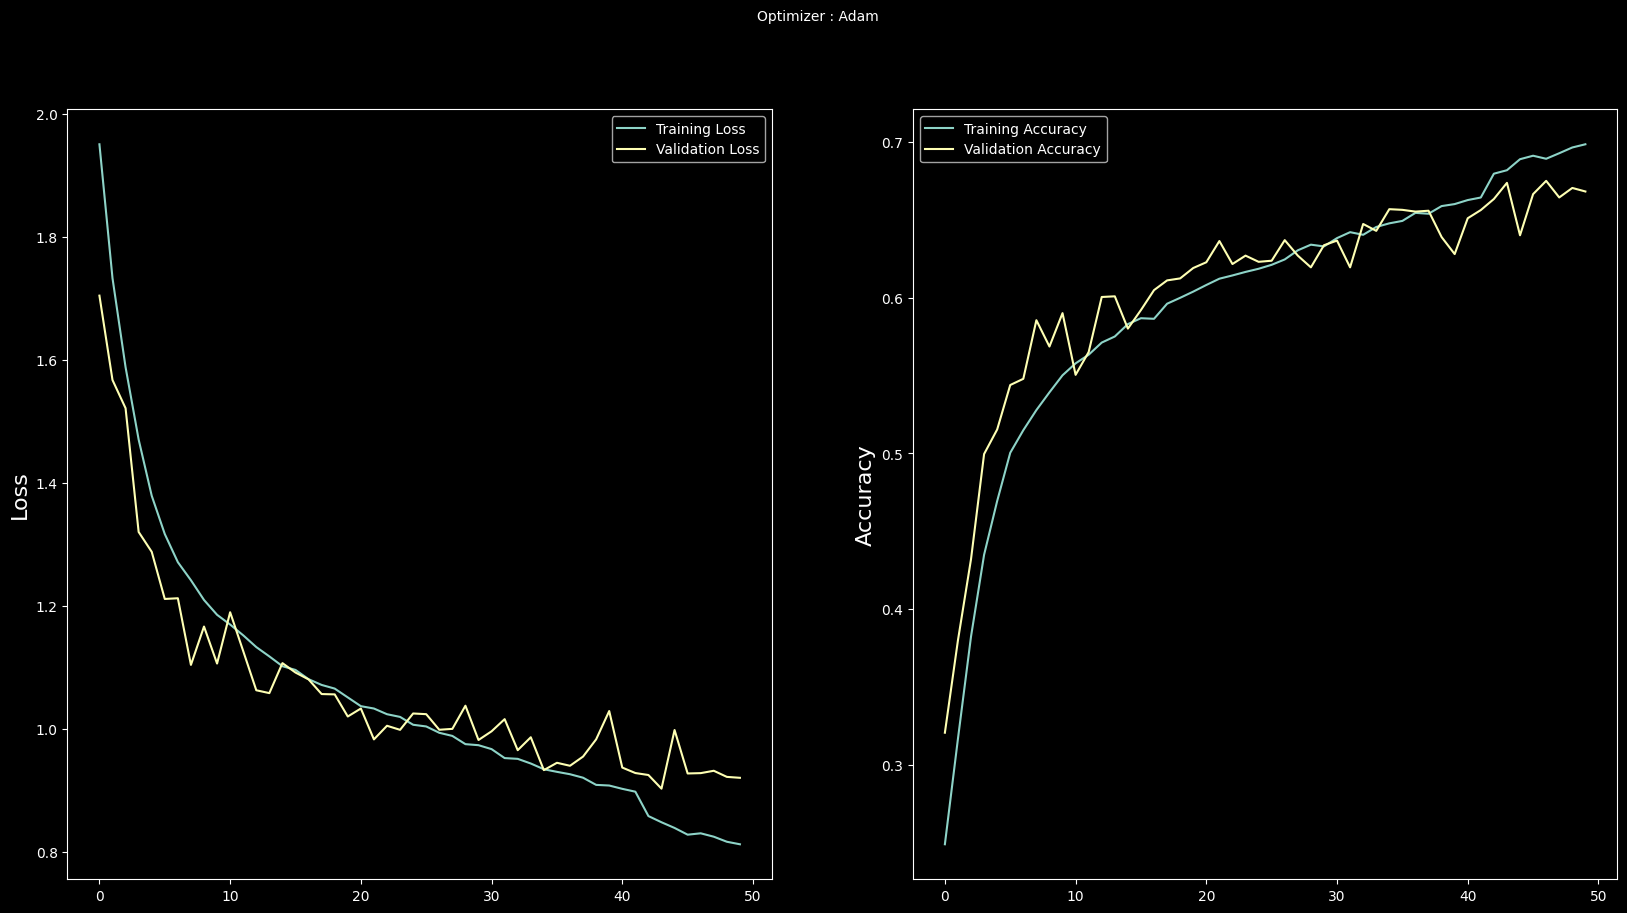

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#Saving and downloading the model

from google.colab import files
model.save('model.h5')
files.download('model.h5')

# **Conclusion**

**Training Loss:**
Starts at: 1.9506 (Epoch 1)
Ends at: 0.8122 (Epoch 50)

**Validation Loss:**
Starts at: 1.7045 (Epoch 1)
Ends at: 0.9203 (Epoch 50)

**Training Accuracy:**
Starts at: 0.2489 (Epoch 1)
Ends at: 0.6985 (Epoch 50)

**Validation Accuracy:**
Starts at: 0.3206 (Epoch 1)
Ends at: 0.6682 (Epoch 50)

- The training loss decreased from 1.9506 to 0.8122, and the training accuracy increased from 0.2489 to 0.6985 over 50 epochs, indicating effective learning.  

- The validation metrics closely follow the training metrics, suggesting good generalization. 

- The best validation accuracy is 0.67500.